<a href="https://colab.research.google.com/github/mmagavi/FinalProject1291/blob/main/FinalProject1291.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project: Classifying Brain Tumors With Convolutional Neural Networks and a Foundational Model**

## **Importing the Data**

Importing the data from https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

**cjdata.label:** 1 for meningioma, 2 for glioma, 3 for pituitary tumor

**cjdata.PID:** patient ID

**cjdata.image:** image data

**cjdata.tumorBorder:** a vector storing the coordinates of discrete points on tumor border.

		For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
		It was generated by manually delineating the tumor border. So we can use it to generate
		binary image of tumor mask.

**cjdata.tumorMask:** a binary image with 1s indicating tumor region


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing and Downloading Images
!gdown 1p_q_wHJZQIEeinSUskvQHtqu88s2gfq8
!gdown 1EQRVW5M31GzZjEXnULygxpvBnIGOZ6WA
!gdown 1QxVOVJ89AHKQkbW-3Ftu-ajcDuzTTrIZ
!gdown 1A1dYyanURV6B7EPgI7VS-Y6tZuheEjJy
!unzip brainTumorDataPublic_22993064.zip -d tumor_data
!unzip brainTumorDataPublic_15332298.zip -d tumor_data
!unzip brainTumorDataPublic_7671532.zip -d tumor_data
!unzip brainTumorDataPublic_1766.zip -d tumor_data

In [ ]:
!ls tumor_data # Checking Data was loaded correctly into folder.

In [48]:
#VGG19
import time
import os
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]
plt.ion()
import cv2
import pickle
import numpy as np
from scipy.spatial.distance import pdist, squareform

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torchsummary import summary
import json
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

vgg19 = models.vgg19(weights="IMAGENET1K_V1").to(device)
vgg19.eval()
summary(vgg19, (3, 224, 224))


Running on cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14    

(512, 512)
(512, 512, 3)


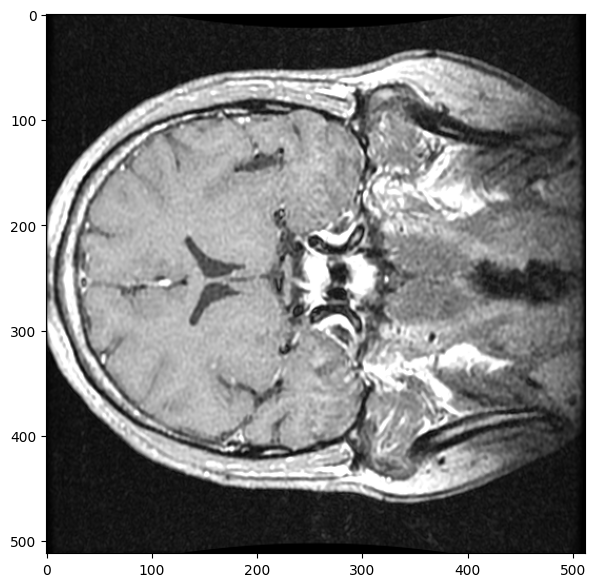

In [112]:
import h5py

image_path = "tumor_data/1571.mat" #using one image to see model works

# Open the .mat file using h5py
with h5py.File(image_path, 'r') as file:
    label = file['cjdata']['label'][()][0, 0]
    patient_id = file['cjdata']['PID'][()][0, 0]
    image_data = file['cjdata']['image'][()]
    tumor_border = file['cjdata']['tumorBorder'][()].flatten()

# I think the images are greyscale, so do not have the rgb channels (have to add)
print(image_data.shape)  # (512, 512)
rgb_batch = np.repeat(image_data[..., np.newaxis], 3, -1)
print(rgb_batch.shape)  # (512, 512, 3)
# plt.imshow(image_data)
plt.imshow(rgb_batch)

In [113]:
#similar code to assignment 7

!gdown 13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj #imagenet_classes.json

def preprocess(image_data):
    image = Image.fromarray((image_data * 255).astype(np.uint8))

    # Resize and normalize using PyTorch transforms
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    normalized_image = transform(image)
    return normalized_image

PATH_TO_LABELS = 'imagenet_classes.json'
with open(PATH_TO_LABELS, 'r') as f:
    imagenet_classes = json.load(f)

def decode_preds(outputs, class_names=imagenet_classes):
  # Assuming outputs is the tensor of model outputs
  softmax_outputs = F.softmax(outputs, dim=1)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[str(idx)] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()

  # Print or return the results
  for label, score in zip(predicted_class_labels, probability_scores):
      print(f'\nClass: {label}, Probability: {score}')


Downloading...
From: https://drive.google.com/uc?id=13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj
To: /content/imagenet_classes.json
100% 32.6k/32.6k [00:00<00:00, 69.9MB/s]



Class: Petri dish, Probability: 0.27172476053237915


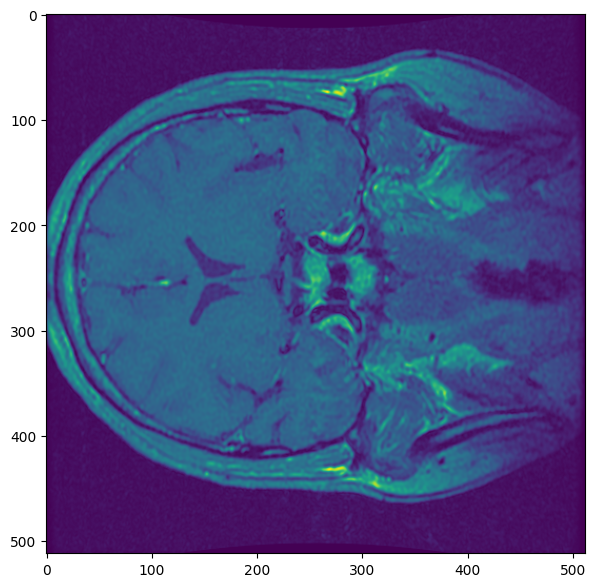

In [114]:
array = preprocess(rgb_batch)

with torch.no_grad():
  vector = vgg19(array[None, :, :, :])

# Display the image
plt.imshow(image_data) #coloured by plt.imshow()
decode_preds(vector)
#prediction is not correct, but not crazy

## **Preprocessing Data**